## Setup

### Download example data

**NOTE:** Feel free to replace our example image with your own photo.

In [ ]:
# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
# !ls -lh

In [ ]:
# EXAMPLE_IMAGE_PATH = "dog.jpeg"

## Download and configure the model

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [ ]:
# !pip install -q transformers flash_attn timm einops peft
# !pip install -q roboflow git+https://github.com/roboflow/supervision.git

In [1]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

# from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [2]:
CHECKPOINT = "microsoft/Florence-2-large"
REVISION = 'refs/heads/main'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

## Run inference with pre-trained Florence-2 model

In [3]:
# # @title Example object detection inference

# image = Image.open(EXAMPLE_IMAGE_PATH)
# task = "<OD>"
# text = "<OD>"

# inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
# generated_ids = model.generate(
#     input_ids=inputs["input_ids"],
#     pixel_values=inputs["pixel_values"],
#     max_new_tokens=1024,
#     num_beams=3
# )
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
# response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
# detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

# bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

# image = bounding_box_annotator.annotate(image, detections)
# image = label_annotator.annotate(image, detections)
# image.thumbnail((600, 600))
# image

In [4]:
# # @title Example image captioning inference

# image = Image.open(EXAMPLE_IMAGE_PATH)
# task = "<DETAILED_CAPTION>"
# text = "<DETAILED_CAPTION>"

# inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
# generated_ids = model.generate(
#     input_ids=inputs["input_ids"],
#     pixel_values=inputs["pixel_values"],
#     max_new_tokens=1024,
#     num_beams=3
# )
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
# response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
# response

In [5]:
# # @title Example caption to phrase grounding inference

# image = Image.open(EXAMPLE_IMAGE_PATH)
# task = "<CAPTION_TO_PHRASE_GROUNDING>"
# text = "<CAPTION_TO_PHRASE_GROUNDING> In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds."

# inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
# generated_ids = model.generate(
#     input_ids=inputs["input_ids"],
#     pixel_values=inputs["pixel_values"],
#     max_new_tokens=1024,
#     num_beams=3
# )
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
# response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
# detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

# bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

# image = bounding_box_annotator.annotate(image, detections)
# image = label_annotator.annotate(image, detections)
# image.thumbnail((600, 600))
# image

## Fine-tune Florence-2 on custom dataset

### Download dataset from Roboflow Universe

In [6]:
# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
# version = project.version(4)
# dataset = version.download("florence2-od")

In [7]:
# !head -n 5 {dataset.location}/train/annotations.jsonl

#### Load DOTA annotations

In [8]:
# from supervision.dataset.formats.coco import load_coco_annotations
# import shutil

# for type in ['train', 'test', 'valid']:
#   classes, images, annotation_dict = load_coco_annotations(
#                   images_directory_path=f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_scale_0.5/{type}', 
#                   annotations_path=f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_scale_0.5/{type}/_annotations.coco.json',
#                     force_masks=False
#               )
#   # print(images[1], annotation_dict[images[0]], classes)

#   # resize image to 640 px and create .txt files of annotations in yolo axis aligned format and then convert it to jsonl format
#   image_dir = f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_640px/{type}'
#   label_dir = f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_640px/{type}_labels'

#   if os.path.exists(image_dir):
#       shutil.rmtree(image_dir)
#   if os.path.exists(label_dir):
#       shutil.rmtree(label_dir)

#   if not os.path.exists(image_dir):
#       os.makedirs(image_dir)
#   if not os.path.exists(label_dir):
#       os.makedirs(label_dir)

#   for image in images:
#       if os.path.exists(image):
#         img_name = os.path.basename(image)
#         img = Image.open(image)
#         img_width, img_height = img.size
#         img = img.resize(size=(640,640))
#         img.save(f'{image_dir}/{img_name}','PNG')
#         bbox = annotation_dict[image].xyxy
#         class_id = annotation_dict[image].class_id
#         class_id = class_id.reshape(-1,1)
#         if len(bbox):
#             width = (bbox[:,[2]] - bbox[:,[0]])/img_width
#             height = (bbox[:,[3]] - bbox[:,[1]])/img_height
#             xcenter = bbox[:, [0]]/img_width + width/2
#             ycenter = bbox[:, [1]]/img_height + height/2
#             bbox = np.hstack([class_id, xcenter, ycenter, width, height])
#             np.savetxt(fname = f'{label_dir}/{img_name[:-4]}.txt', X = bbox, fmt = '%1d %1.6f %1.6f %1.6f %1.6f')

# os.symlink('/home/shataxi.dubey/shataxi_work/DOTA_dataset/modified_DOTA_dataset_scale_0.5/valid/florence_2_dota_obb_annotations.jsonl',
#            '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_640px/valid/florence_2_dota_obb_annotations.jsonl')

In [9]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [70]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

dataset_location = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_coco_train_test_640px'
BATCH_SIZE = 6
NUM_WORKERS = 0
output = 'obb'

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    # jsonl_file_path = f"{dataset_location}/train/annotations.jsonl",
    jsonl_file_path = f"{dataset_location}/train/florence_2_dota_obb_annotations.jsonl",
    image_directory_path = f"{dataset_location}/train/"
)
val_dataset = DetectionDataset(
    # jsonl_file_path = f"{dataset_location}/valid/annotations.jsonl",
    jsonl_file_path = f"{dataset_location}/valid/florence_2_dota_obb_annotations.jsonl",
    image_directory_path = f"{dataset_location}/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [11]:
# train_dataset[0][1]

In [12]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# w, h = train_dataset[0][2].size
# ax.imshow(train_dataset[0][2])
# xmin, ymin , xmax, ymax = 525,293,685,379
# x = np.array([xmin, xmax, xmax, xmin, xmin])/1000*w
# y = np.array([ymin, ymin, ymax, ymax, ymin])/1000*h
# ax.plot(x, y)

In [13]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 833,118,920 || trainable%: 0.4962


In [14]:
torch.cuda.empty_cache()


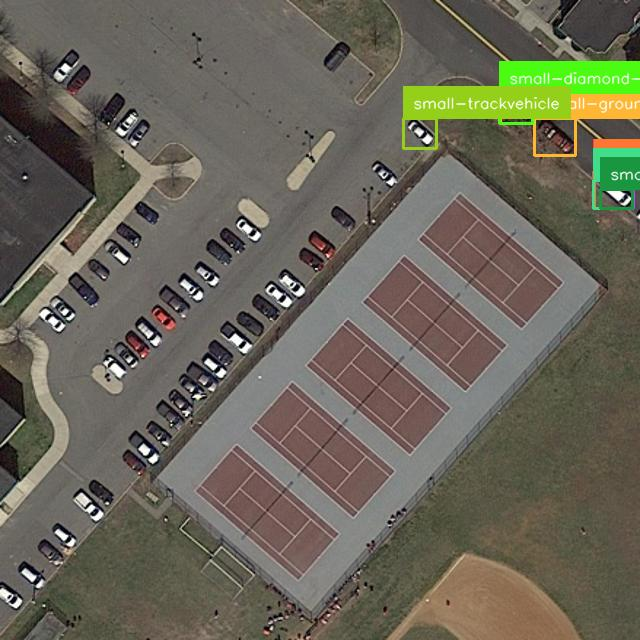
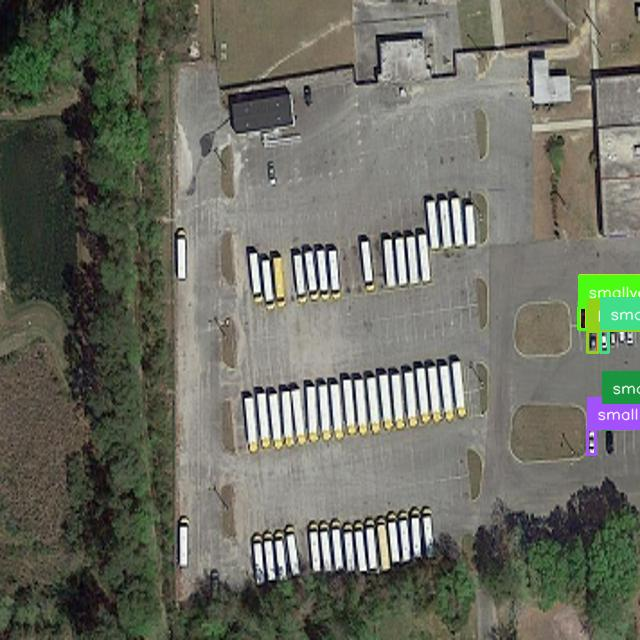
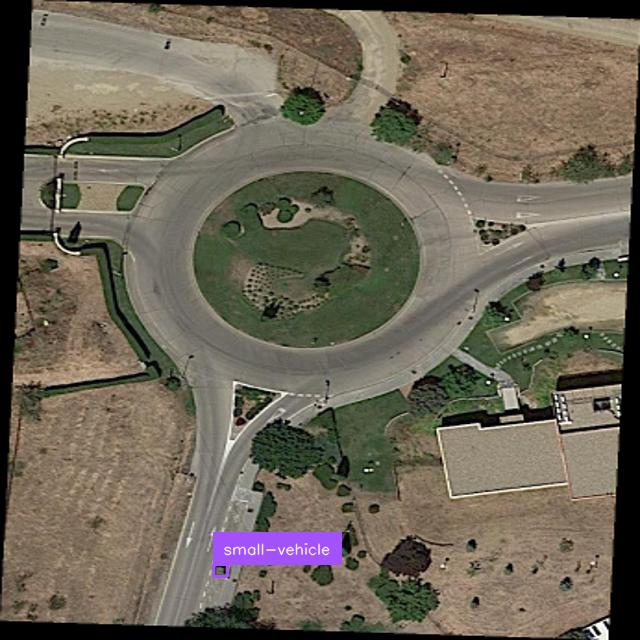
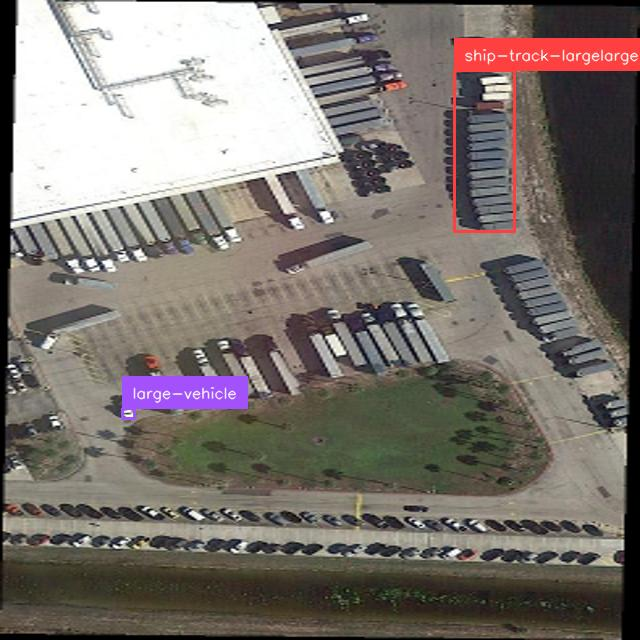

: 

In [ ]:
# for getting OBB labels choosen <OCR_WITH_REGION> task prompt so that 8 coords are available, slight changes are done in regex
def obb_format_processing(generated_text, image_size):
    answer = processor.post_processor.parse_ocr_from_text_and_spans(text = generated_text, 
                                                            pattern = r'([a-zA-Z0-9- ]+)<loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)>',
                                                            image_size = image_size,)
    bboxes = [_od_instance['quad_box'] for _od_instance in answer]
    labels = [str(_od_instance['text']) for _od_instance in answer]
    answer = {'quad_boxes': bboxes, 'labels': labels}
    answer = {'<OCR_WITH_REGION>': answer}
    return answer

# @title Run inference with pre-trained Florence-2 model on validation dataset
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_vlm(vlm = 'florence_2', result = response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to render model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        if output == 'axis_aligned':
            answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        else:
            answer = obb_format_processing(generated_text, image_size = image.size)
                
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

## Fine-tune Florence-2 on custom object detection dataset

In [16]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 1)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 1)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [ ]:
%%time

EPOCHS = 100
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

## Fine-tuned model evaluation

In [18]:
# @title Check if the model can still detect objects outside of the custom dataset

# image = Image.open(EXAMPLE_IMAGE_PATH)
# task = "<OD>"
# text = "<OD>"

# inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
# generated_ids = peft_model.generate(
#     input_ids=inputs["input_ids"],
#     pixel_values=inputs["pixel_values"],
#     max_new_tokens=1024,
#     num_beams=3
# )
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
# response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
# detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

# bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

# image = bounding_box_annotator.annotate(image, detections)
# image = label_annotator.annotate(image, detections)
# image.thumbnail((600, 600))
# image

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

## Save fine-tuned model on hard drive

In [20]:
peft_model.save_pretrained("/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_training/scale_0.5_640px_obb")
processor.save_pretrained("/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_training/scale_0.5_640px_obb")
!ls -la /home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_training/scale_0.5_640px

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 21476
drwxrwxr-x 2 shataxi.dubey shataxi.dubey     4096 Apr 25 03:17 .
drwxrwxr-x 8 shataxi.dubey shataxi.dubey     4096 Apr 26 17:46 ..
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey      821 Apr 25 03:17 adapter_config.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey 16582384 Apr 25 03:17 adapter_model.safetensors
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey    22410 Apr 25 03:17 added_tokens.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey   456318 Apr 25 03:17 merges.txt
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey      631 Apr 25 03:17 preprocessor_config.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey     5100 Apr 25 03:17 README.md
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey   146627 Apr 25 03:17 special_tokens_map.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey   197689 Apr 25 03:17 tokenizer_config.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey  3747961 Apr 25 03:17 tokenizer.json
-rw-rw-r-- 1 shataxi.dubey shataxi.dubey   798293 Apr 25 03:17 vocab.json


In [ ]:
model_id_or_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dota_training/scale_0.5_640px_obb'
processor = AutoProcessor.from_pretrained(model_id_or_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
            model_id_or_path,
            trust_remote_code=True).to(DEVICE)

In [64]:
# @title Collect predictions

PATTERN = r'([a-zA-Z0-9 ]+ of [a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

# CLASSES = extract_classes(train_dataset)

CLASSES = ['plane',
 'baseball-diamond',
 'bridge',
 'ground-track-field',
 'small-vehicle',
 'large-vehicle',
 'ship',
 'tennis-court',
 'basketball-court',
 'storage-tank',
 'soccer-ball-field',
 'roundabout',
 'harbor',
 'swimming-pool',
 'helicopter']

class_mapping = {
                'airplane': 'plane',
                'baseballdiamond': 'baseball-diamond',
                'basebase-ball-field': 'baseball-diamond',
                'basediamond': 'baseball-diamond',
                'basketball-track-court': 'basketball-court',
                'large-tankvehicle': 'large-vehicle',
                'small-track-field': 'ground-track-field',
                'soccer-ball': 'soccer-ball-field',
                'soccer-field':'soccer-ball-field',
                'ten-basketball-court': 'tennis-court',
                'ten-court': 'tennis-court',
                'tenniscourt': 'tennis-court',
                'tennis court': 'tennis-court',
                'tennis-court-court': 'tennis-court',
                'tennis racket': 'tennis-court',
                'tennis tennis-court': 'tennis-court',
                'tennis table': 'tennis-court',
                'tennis net': 'tennis-court', 
                'tennis -court': 'tennis-court',
                'vehicle': 'small-vehicle',
                'land vehicle': 'large-vehicle',
                'swimming pool': 'swimming-pool',
                 }

targets = []
predictions = []

for i in tqdm(range(len(val_dataset.dataset))):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    # prefix = '<CAPTION_TO_PHRASE_GROUNDING> plane, baseball-diamond, bridge, ground-track-field, small-vehicle, large-vehicle, ship, tennis-court, basketball-court, storage-tank, soccer-ball-field, roundabout, harbor, swimming-pool, helicopter'
    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    if output == 'axis_aligned':
        prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        # prediction = processor.post_process_generation(generated_text, task="<CAPTION_TO_PHRASE_GROUNDING>", image_size=image.size)
        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        # target = processor.post_process_generation(suffix, task="<CAPTION_TO_PHRASE_GROUNDING>", image_size=image.size)
    else:
        prediction = obb_format_processing(generated_text, image.size)
        target = obb_format_processing(suffix, image.size)

    prediction = sv.Detections.from_vlm(vlm = 'florence_2', result = prediction, resolution_wh=image.size)
    prediction['class_name'] = list(map(lambda name: class_mapping[name] if name in class_mapping else name, prediction['class_name']))
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = sv.Detections.from_vlm(vlm = 'florence_2', result = target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

100%|██████████| 56/56 [08:06<00:00,  8.70s/it]


In [29]:
# generated_text

'</s><s><s><s>small-vehicle<loc_701><loc_177><loc_754><loc_174><loc_757><loc_193><loc_703><loc_197>small-car-vehicles<loc_720><loc_204><loc_776><loc_201><loc_779><loc_220><loc_720><loc_223>small-cars-vehvehicle-veh-vehile-vehicular-vehic-vehica-vehICLE-veh vehicle-vehician-vehical-vehiche-vehici-vehicit-vehlic-vehicia-vehicus-vehicas-vehicol-vehices-veh<pad><pad><pad>vehicle<pad><pad>||||<pad><pad>iamond<pad><pad> ¶<pad><pad> glared<pad><pad> Canaver<pad><pad>��<pad><pad> practition<pad><pad> cannabin<pad><pad> shenan<pad><pad>pmwiki<pad><pad> gobl<pad><pad> meager<pad><pad> Leban<pad><pad> \'/<pad><pad> […]<pad><pad>______<pad><pad> ----------------------------------------------------------------<pad><pad>about<pad><pad> =================================<pad><pad>••<pad><pad>��<pad><pad> teasp<pad><pad> pestic<pad><pad> reluct<pad><pad> disingen<pad><pad>imming<pad><pad> councill<pad><pad>soc<pad><pad> --------------------------------<pad><pad> misunder<pad><pad> enthusi<pad><pad>@@@@

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.imshow(image)
# width , height = image.size
# x1, y1, x2, y2, x3, y3, x4, y4 = [720, 204, 776, 201, 779,220,720,223]
# x1, x2, x3, x4 = np.array([x1, x2, x3, x4])/1000 *width
# y1, y2, y3, y4 = np.array([y1, y2, y3, y4])/1000 *height
# ax.plot([x1, x2,x3,x4,x1], [y1, y2, y3, y4, y1], color = 'red')

In [61]:
# task_answer_post_processing_type  = processor.tasks_answer_post_processing_type['<OCR>']
# task_answer = processor.post_processor(text = generated_text, image_size= (640, 640), parse_tasks = task_answer_post_processing_type)
# print(task_answer)
# task_answer = processor.post_processor.parse_ocr_from_text_and_spans(text = generated_text, 
#                                                         pattern = r'([a-zA-Z0-9- ]+)<loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)>',
#                                                         image_size= (640, 640),)
# bboxes = [_od_instance['quad_box'] for _od_instance in task_answer]
# labels = [str(_od_instance['text']) for _od_instance in task_answer]
# task_answer = {'quad_boxes': bboxes, 'labels': labels}
# task_answer = {'<OCR_WITH_REGION>': task_answer}
# task_answer = sv.Detections.from_vlm(vlm = 'florence_2', result = task_answer, resolution_wh=image.size)
# task_answer

Detections(xyxy=array([[448.96    , 111.68    , 484.8     , 126.399994],
       [461.12    , 128.95999 , 498.87997 , 143.04    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['small-vehicle', 'small-car-vehicles'], dtype='<U18'), 'xyxyxyxy': array([[[448.96    , 113.6     ],
        [482.87997 , 111.68    ],
        [484.8     , 123.84    ],
        [450.24    , 126.399994]],

       [[461.12    , 130.87999 ],
        [496.96    , 128.95999 ],
        [498.87997 , 141.12    ],
        [461.12    , 143.04    ]]], dtype=float32)}, metadata={})

In [65]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.10
map50: 0.13
map75: 0.11


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.704545,0.062249,0.114391,93.0,39.0,1401.0,1494.0
0,0.3,0.659091,0.058233,0.107011,87.0,45.0,1407.0,1494.0
0,0.5,0.643939,0.056894,0.104551,85.0,47.0,1409.0,1494.0
0,0.7,0.598485,0.052878,0.097171,79.0,53.0,1415.0,1494.0




Plot of Confusion matrix at IoU 0.7


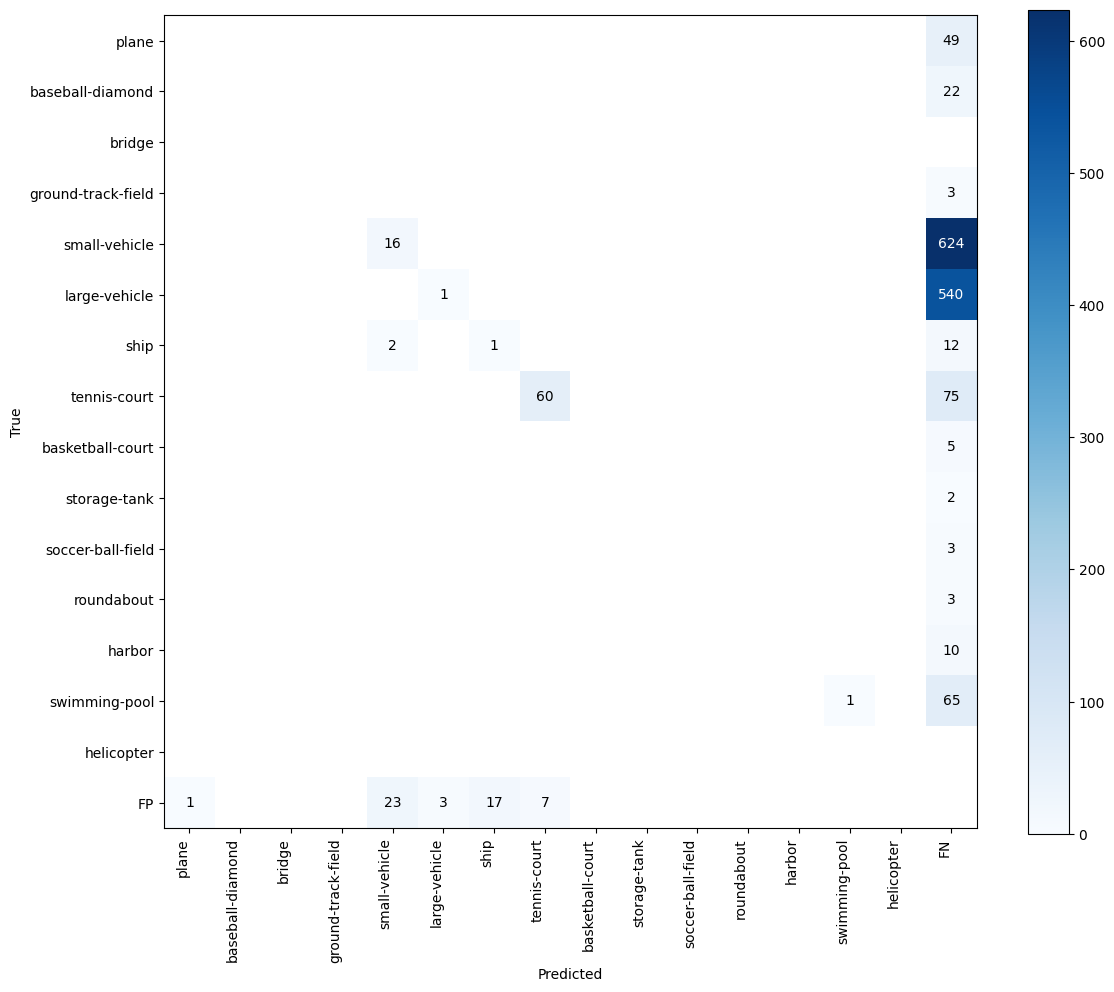

In [66]:
# @title Calculate Confusion Matrix
import pandas as pd

df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
for iou in [0.1,0.3,0.5, 0.7]:
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold = 0.25, # florence_2 does not give confidence score so no use of conf_threshold  
        iou_threshold=iou
    )

    # calculate precision recall and f1-score
    cm = confusion_matrix.matrix
    tp = cm.diagonal().sum() - cm[-1][-1]
    predicted_positives = cm[:,:-1].sum()
    actual_positives = cm[:-1, :].sum()
    precision = tp/ (predicted_positives + 1e-9)
    recall = tp/ (actual_positives + 1e-9)
    f1_score = 2*precision*recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp

    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])
display(df)

print(f'\n\nPlot of Confusion matrix at IoU {iou}')
_ = confusion_matrix.plot()

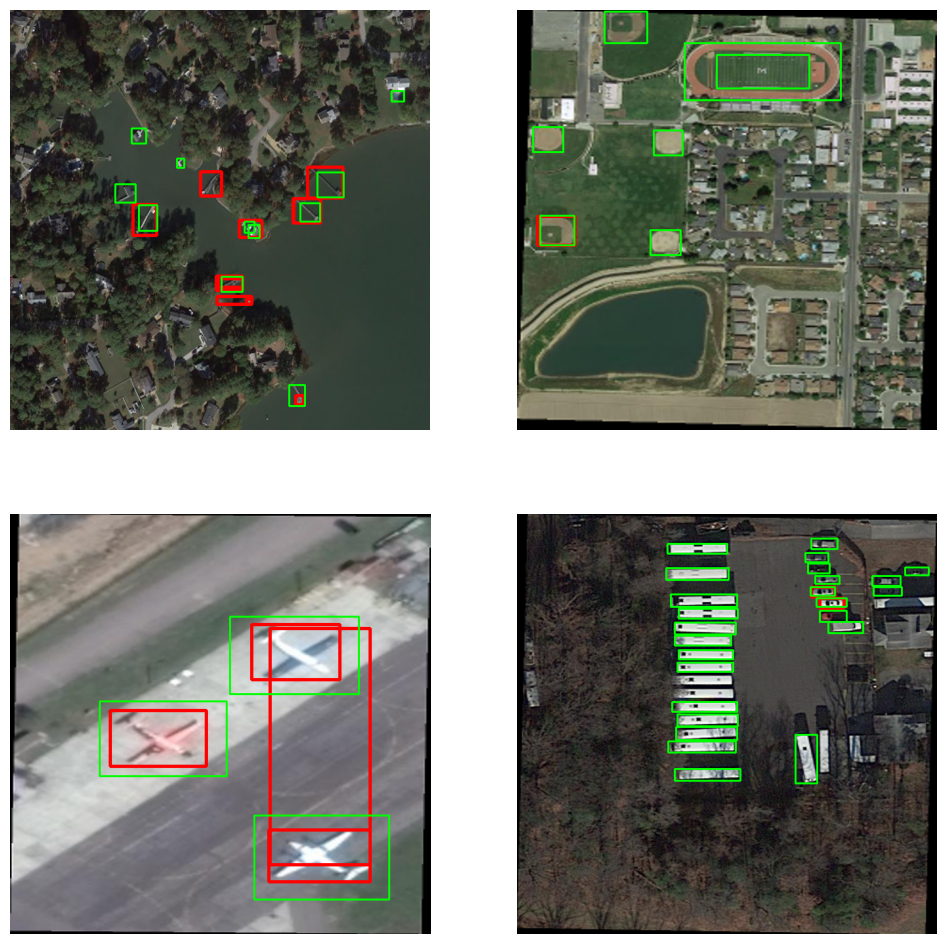

In [ ]:
from supervision.geometry.core import Position

from maestro.trainer.models.florence_2.inference import predict

annotated_images = []

for i in range(52,56):
    task, suffix, image = val_dataset[i]
    generated_text = predict(model=model, processor=processor, image=image, prefix=f"{task}")

    if output == 'axis_aligned':
        result = processor.post_process_generation(text=generated_text, task=task, image_size=(image.width, image.height))
        target = processor.post_process_generation(suffix, task=task, image_size=image.size)
    else:
        result = obb_format_processing(generated_text, image.size)
        target = obb_format_processing(suffix, image.size)

    detections = sv.Detections.from_vlm(vlm="florence_2", result=result, resolution_wh=image.size)
    target = sv.Detections.from_vlm(vlm="florence_2", result=target, resolution_wh=image.size)

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness = 4, color=sv.Color(r=255, g=0, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=detections
    )
    annotated_image = sv.LabelAnnotator(text_scale=1, text_thickness=0, text_position= Position.TOP_CENTER ,smart_position=True, color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=detections
    )

    annotated_image = sv.BoxAnnotator(thickness = 2, color=sv.Color(r=0, g=255, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=target
    )
    
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (2,2))


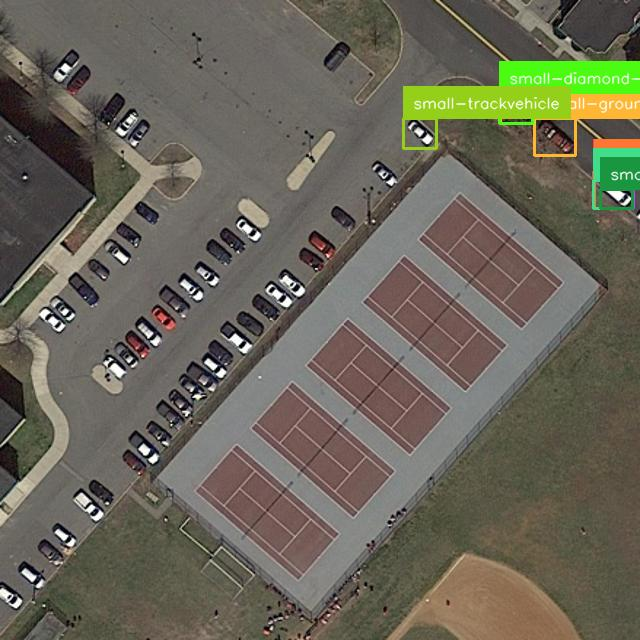
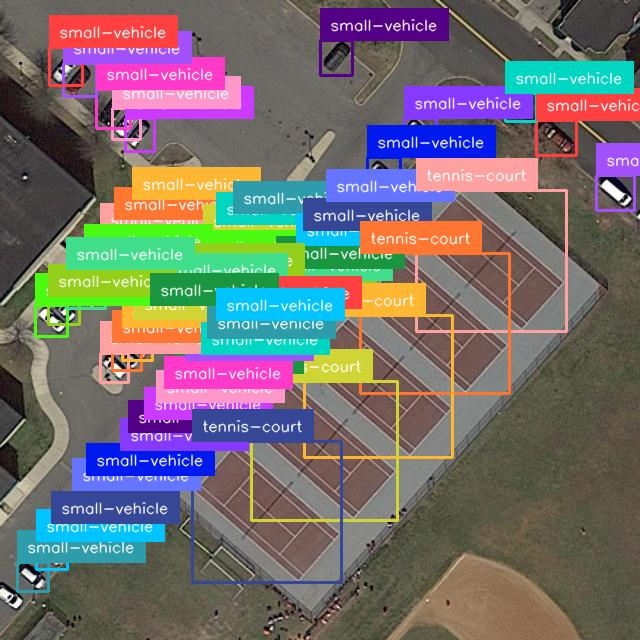
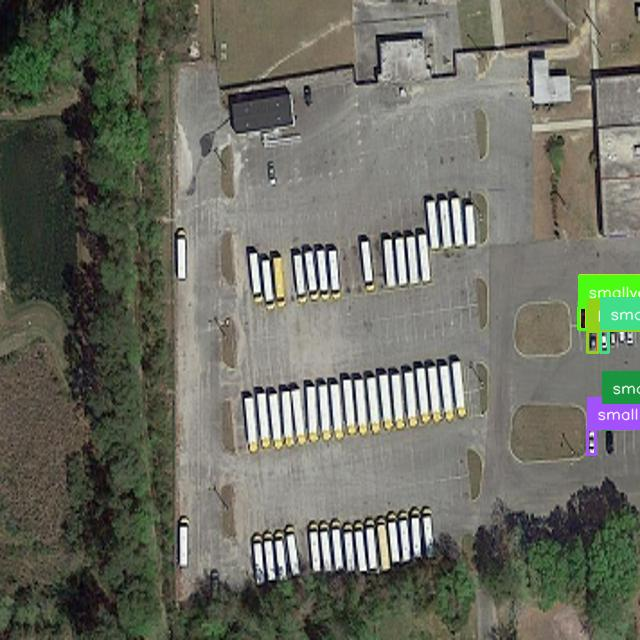
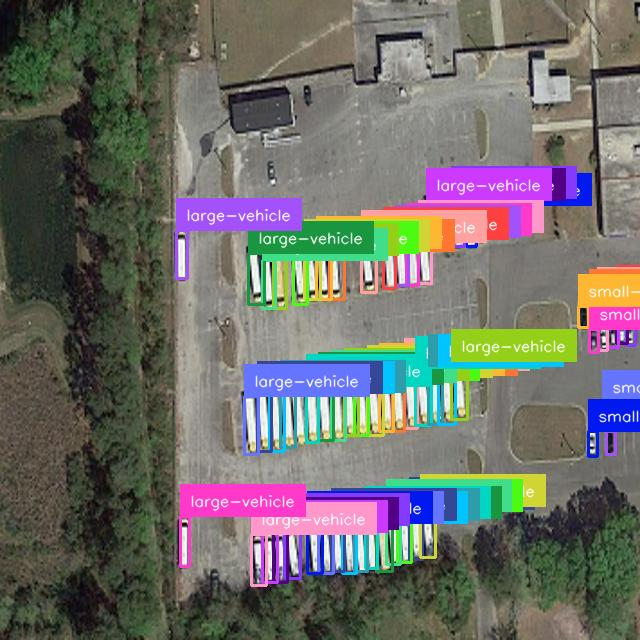

In [ ]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

from h11 import Response


def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response, ground_truth_answer):
    try:
        detections = sv.Detections.from_vlm(vlm = 'florence_2', result = response, resolution_wh=image.size)
        image1 = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image1 = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image1, detections)

        ground_truth_detections = sv.Detections.from_vlm(vlm = 'florence_2', result = ground_truth_answer, resolution_wh=image.size)
        image2 = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), ground_truth_detections)
        image2 = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image2, ground_truth_detections)
    except:
        print('failed to render model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image1, resize=(128, 128))}" />
    # <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
    <img style="width:256px; height:256px;" src="{render_inline(image2, resize=(128, 128))}" />
    # <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(ground_truth_answer))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        # prefix = "<CAPTION_TO_PHRASE_GROUNDING> plane, baseball-diamond, bridge, ground-track-field, small-vehicle, large-vehicle, ship, tennis-court, basketball-court, storage-tank, soccer-ball-field, roundabout, harbor, swimming-pool, helicopter"
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        if output == 'axis_aligned':
            answer = processor.post_process_generation(generated_text, task='<CAPTION_TO_PHRASE_GROUNDING>', image_size=image.size)
            ground_truth_answer = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        else:
            answer = obb_format_processing(generated_text, image.size)
            ground_truth_answer = obb_format_processing(suffix, image.size)

        html_out += render_example(image, answer, ground_truth_answer)
        
    display(HTML(html_out))

render_inference_results(model, val_dataset, 2)